In [1]:
import warnings
import numpy as np
import pandas as pd
from plscan import PLSCAN
from hdbscan import HDBSCAN
from itertools import product
from collections import defaultdict

from lib.plotting import *
from lib.drawing import regplot_lowess_ci

configure_matplotlib()  # uses latex for text rendering!
data = np.load("data/clusterable/sources/clusterable_data.npy")

## PLSCAN

In [2]:
c = PLSCAN(min_samples=5).fit(data)

Layers

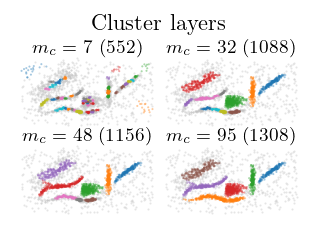

In [ ]:
layers = c.cluster_layers(max_peaks=4)

sized_fig(0.32, aspect=0.7)
for i, (size, labels, probs) in enumerate(layers):
    plt.subplot(2, 2, i + 1)
    mask = labels > -1
    plt.scatter(*data[~mask].T, color="silver", s=1, alpha=0.4, linewidth=0)
    plt.scatter(
        *data[mask].T,
        c=labels[mask] % 10,
        s=1,
        alpha=0.4,
        linewidth=0,
        vmax=9,
        cmap="tab10",
    )
    idx = np.searchsorted(c._persistence_trace.min_size, size)
    plt.title(
        f"$m_c={int(size)}$ ({c._persistence_trace.persistence[idx]:.0f})",
        fontsize=fontsize["footnote"],
        y=0.85,
    )
    plt.axis("off")
plt.suptitle("Cluster layers", y=1)
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0, wspace=0)
plt.savefig("images/plscan_cluster_layers.pdf", pad_inches=0)
plt.show()

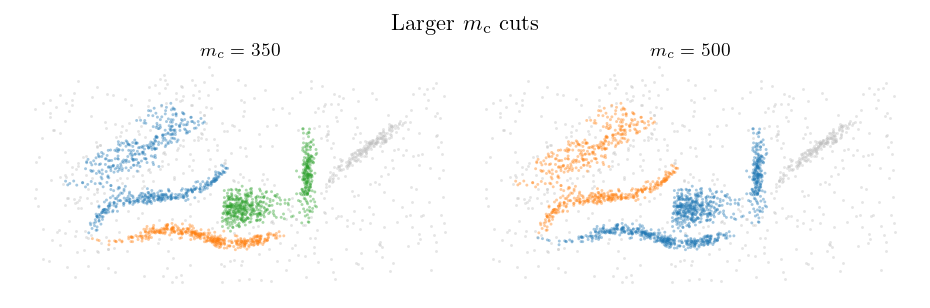

In [ ]:
sized_fig(1, 0.618 / 2)
for i, mc in enumerate([350, 500]):
    plt.subplot(1, 2, i + 1)
    labels, probs = c.min_cluster_size_cut(mc)
    mask = labels != -1
    plt.scatter(*data[~mask].T, color="silver", s=2, alpha=0.4, linewidth=0)
    plt.scatter(
        *data[mask].T,
        c=labels[mask] % 10,
        s=2,
        alpha=0.4,
        linewidth=0,
        vmax=9,
        cmap="tab10",
    )
    plt.title(
        f"$m_c={int(mc)}$",
        fontsize=fontsize["footnote"],
        y=0.95,
    )
    plt.axis("off")
plt.suptitle("Larger $m_{\\rm c}$ cuts", y=1)
plt.subplots_adjust(0, 0, 1, 0.85, 0, 0)
plt.savefig("images/plscan_larger_layers.pdf", pad_inches=0)
plt.show()

Leaf tree

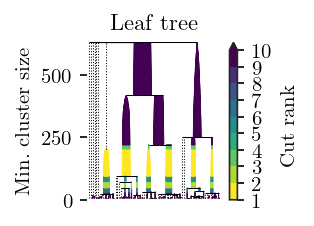

In [169]:
sized_fig(0.32, 0.7)
c.leaf_tree_.plot(leaf_separation=0.05)
plt.title("Leaf tree")
plt.ylabel("Min.~cluster size")
plt.subplots_adjust(0.26, 0.06, 0.84, 0.84)
plt.savefig("images/plscan_leaf_tree.pdf", pad_inches=0)
plt.show()

Persistence trace

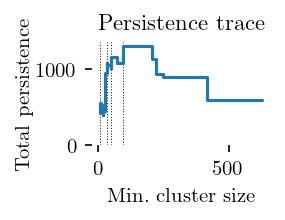

In [170]:
sized_fig(0.32, 0.7)
for size, _, _ in layers:
    plt.axvline(size, color="k", lw=0.5, ls=":", alpha=1)
c.persistence_trace_.plot()
plt.title("Persistence trace")
plt.ylabel("Total persistence", labelpad=1)
plt.xlabel("Min.~cluster size")
plt.subplots_adjust(0.28, 0.33, 0.9, 0.84)
plt.savefig("images/plscan_persistence_trace.pdf", pad_inches=0)
plt.show()

Parameter sensitivity

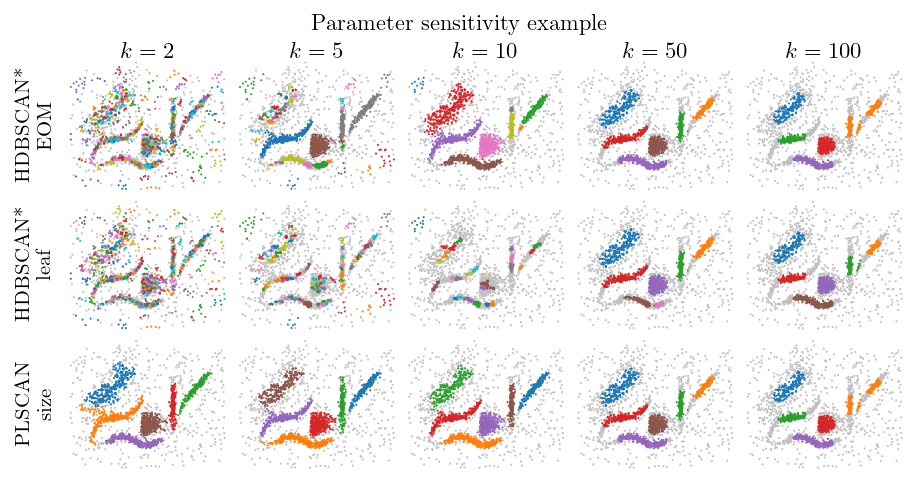

In [ ]:
sized_fig(1, 0.85 / 5 * 3)
count = 1
for j, (alg, kwargs, name) in enumerate(
    [
        (HDBSCAN, {}, "HDBSCAN*\nEOM"),
        (HDBSCAN, {"cluster_selection_method": "leaf"}, "HDBSCAN*\nleaf"),
        (PLSCAN, {}, "PLSCAN\nsize"),
    ]
):
    for i, size in enumerate([2, 5, 10, 50, 100]):
        _c = alg(min_samples=size, min_cluster_size=size, **kwargs).fit(data)
        plt.subplot(3, 5, count)
        count += 1
        plot_kwargs = dict(s=1, cmap="tab10", vmax=9, vmin=0, edgecolors="none")
        mask = _c.labels_ == -1
        plt.scatter(*data[mask].T, color="silver", s=1, edgecolors="none")
        plt.scatter(*data[~mask].T, c=_c.labels_[~mask] % 10, **plot_kwargs)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(name)
        if j == 0:
            plt.title(f"$k={size}$", y=0.9)
plt.suptitle("Parameter sensitivity example", y=1)
plt.subplots_adjust(0.06, 0, 1, 0.91, hspace=0, wspace=0)
plt.savefig("images/plscan_parameter_example.pdf", pad_inches=0)
plt.show()

Modelled probability density profile

In [2]:
def pdf_order(tree, current_node, bonus=None):
    children = tree.child[tree.parent == current_node]
    if bonus is not None:
        children = np.concatenate([bonus, children])
    if len(children) == 0:
        return [current_node]
    else:
        sorted_children = np.concatenate([children[0::2], children[1::2][::-1]])
        return sum([pdf_order(tree, child) for child in sorted_children], [])

In [ ]:
def density_plot(tree, N, color):
    density_plot_order = np.array(
        pdf_order(tree, N + 1, np.flatnonzero(tree.parent == N))
    )
    density_values = np.empty(density_plot_order.shape[0])
    for idx, i in enumerate(density_plot_order):
        density_values[idx] = np.exp(-100 * tree.distance[tree.child == i][0])
    plt.gca().fill_between(
        np.arange(density_values.shape[0]), density_values, color=color
    )
    return density_plot_order

In [ ]:
def label_line(labels, plot_order):
    for idx, i in enumerate(plot_order):
        label = labels[i]
        label_color = f"C{label}" if label != -1 else "silver"
        plt.plot(
            [idx - 0.5, idx + 0.5],
            [-0.04, -0.04],
            color=label_color,
            linewidth=4,
            solid_capstyle="butt",
        )

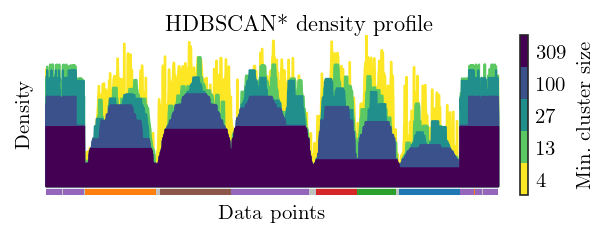

In [5]:
sized_fig(0.66, 0.7 / 2)
mcs = [4, 13, 27, 100, 309]
palette = plt.cm.viridis_r.resampled(len(mcs))
for i, mc in enumerate(mcs):
    c2 = PLSCAN(min_samples=2, min_cluster_size=int(mc)).fit(data)
    plot_order = density_plot(c2._condensed_tree, data.shape[0], palette.colors[i])
    if mc == 100:
        labels, _ = c2.min_cluster_size_cut(mc)
        label_line(labels, plot_order)
plt.ylim(-0.05, 0.8)
plt.xticks([])
plt.yticks([])
plt.ylabel("Density", labelpad=-5)
plt.xlabel("Data points")
plt.suptitle("HDBSCAN* density profile", y=1, va="top")
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(0, len(mcs)), cmap=palette),
    ax=plt.gca(),
    label="Min.~cluster size",
    ticks=[i + 0.5 for i in range(len(mcs))],
    pad=0,
)
cb.ax.tick_params(length=0)
cb.set_ticklabels([str(int(mc)) for mc in mcs])
plt.subplots_adjust(0.035, 0.13, 1.02, 0.9, hspace=0, wspace=0)
plt.savefig("images/plscan_density_smoothing.pdf", pad_inches=0)
plt.show()

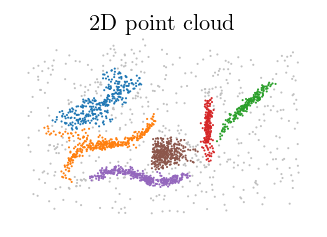

In [6]:
sized_fig(0.33, 0.7)
mask = labels == -1
plot_kwargs = dict(s=1, cmap="tab10", vmax=9, vmin=0, edgecolors="none")
plt.scatter(*data[mask].T, color="silver", s=1, edgecolors="none")
plt.scatter(*data[~mask].T, c=labels[~mask] % 10, **plot_kwargs)
plt.axis("off")
plt.suptitle("2D point cloud", y=1, va="top")
plt.subplots_adjust(0, 0, 1, 0.92)
plt.savefig("images/plscan_density_smoothing_data.pdf", pad_inches=0)
plt.show()

## Leaf tree explainer

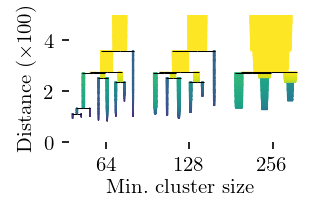

In [ ]:
sized_fig(0.32, 0.66)

yticks = [0, 0.02, 0.04]
symbol = "m_{\\rm c}"
mcs = [64, 128, 256]
for i, mc in enumerate(mcs):
    plt.subplot(1, 3, i + 1)
    c3 = PLSCAN(min_samples=5, min_cluster_size=mc).fit(data)
    c3.condensed_tree_.plot(colorbar=False, leaf_separation=1)
    plt.ylim(0, 0.05)
    if i == 0:
        plt.ylabel("Distance ($\\times 100$)")
        plt.yticks(yticks)
        plt.gca().set_yticklabels([f"${int(y*100)}$" for y in yticks])
    else:
        plt.ylabel("")
        plt.yticks([])
    plt.xticks(np.diff(plt.xlim()) / 2)
    plt.gca().set_xticklabels([f"${mc}$"])
plt.text(
    (1 - 0.17) / 2 + 0.17,
    0.04,
    f"Min.~cluster size",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gcf().transFigure,
    fontsize=fontsize["small"],
)
# plt.suptitle("Condensed trees", y=1)
plt.subplots_adjust(0.2, 0.28, 1, 0.95)
plt.savefig("images/plscan_condensed_trees.pdf", pad_inches=0)
plt.show()

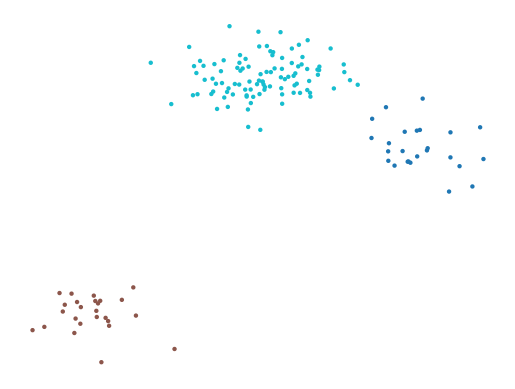

In [5]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(50, centers=2, random_state=1)
X2, y2 = make_blobs(100, centers=1, random_state=5)
X = np.vstack((X1, X2))
y = np.hstack((y1, y2 + y1.max() + 1))

c = PLSCAN(min_samples=10).fit(X)
plt.scatter(*X.T, c=y, s=10, cmap="tab10", edgecolors="none")
plt.axis("off")
plt.show()

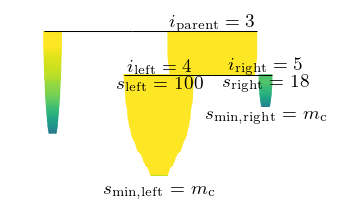

In [32]:
sized_fig(0.32, 0.66)
leaf_separation = 3
t = c.condensed_tree_
sizes = c._condensed_tree.child_size[c._condensed_tree.cluster_rows]
xcoords = t._x_coords(t._leaf_tree.parent) * leaf_separation
t.plot(y="density", leaf_separation=leaf_separation, colorbar=False)
plt.yticks([])
plt.ylabel("")
plt.ylim(0.6, None)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.max_distance[3]),
    r"$i_{\rm parent} = 3$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[4],
    np.exp(-t._leaf_tree.max_distance[4]),
    r"$i_{\rm left} = 4$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[5],
    np.exp(-t._leaf_tree.max_distance[5]),
    r"$i_{\rm right} = 5$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[4],
    np.exp(-t._leaf_tree.min_distance[4]),
    r"$s_{\rm min,left} = m_{\rm c}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[5],
    np.exp(-t._leaf_tree.min_distance[5]),
    r"$s_{\rm min,right} = m_{\rm c}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[4],
    np.exp(-t._leaf_tree.max_distance[4]),
    r"$s_{\rm left} = " + f"{sizes[2]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[5],
    np.exp(-t._leaf_tree.max_distance[5]),
    r"$s_{\rm right} = " + f"{sizes[3]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.subplots_adjust(-0.09, 0.13, 0.84, 0.89)
plt.savefig("images/leaf_tree_explainer_1.pdf", pad_inches=0)
plt.show()

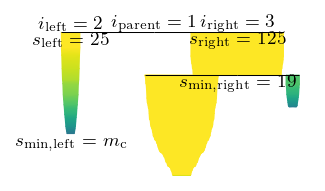

In [31]:
sized_fig(0.32, 0.66)
t.plot(y="density", leaf_separation=leaf_separation, colorbar=False)
plt.yticks([])
plt.ylabel("")
plt.ylim(0.6, None)
plt.text(
    xcoords[1],
    np.exp(-t._leaf_tree.max_distance[1]),
    r"$i_{\rm parent} = 1$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[2],
    np.exp(-t._leaf_tree.max_distance[2]),
    r"$i_{\rm left} = 2$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.max_distance[3]),
    r"$i_{\rm right} = 3$",
    ha="center",
    va="bottom",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[2],
    np.exp(-t._leaf_tree.min_distance[2]),
    r"$s_{\rm min,left} = m_{\rm c}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.min_distance[3]),
    r"$s_{\rm min,right} = 19$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[2],
    np.exp(-t._leaf_tree.max_distance[2]),
    r"$s_{\rm left} = " + f"{sizes[0]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.text(
    xcoords[3],
    np.exp(-t._leaf_tree.max_distance[3]),
    r"$s_{\rm right} = " + f"{sizes[1]:.0f}$",
    ha="center",
    va="top",
    fontsize=fontsize["footnote"],
)
plt.subplots_adjust(0.06, 0.13, 1.03, 0.89)
plt.savefig("images/leaf_tree_explainer_2.pdf", pad_inches=0)
plt.show()

In [ ]:
for r in c._condensed_tree.cluster_rows:
    print(
        c._condensed_tree.parent[r] - X.shape[0],
        c._condensed_tree.child[r] - X.shape[0],
        c._condensed_tree.child_size[r],
        c._condensed_tree.distance[r],
    )

1 2 25.0 8.137202
1 3 125.0 8.137202
3 4 100.0 1.7068086
3 5 18.0 1.7068086


In [180]:
for parent, min_dist, max_dist, min_size, max_size in zip(*c._leaf_tree):
    print(parent, min_dist, max_dist, min_size, max_size)

0 0.0 8.137202 25.0 150.0
0 8.137202 8.137202 25.0 25.0
1 0.85816634 8.137202 10.0 25.0
1 1.7068086 8.137202 18.0 25.0
3 0.47154778 1.7068086 10.0 18.0
3 1.1621531 1.7068086 10.0 18.0


## Computational costs

In [215]:
benchmark_results = pd.read_parquet("data/generated/benchmark_time.parquet")
timeout = 20
alg_names = [
    "plscan (kd-tree)",
    "plscan (ball-tree)",
    "fast_hdbscan",
    "hdbscan",
    "kmeans",
]

In [ ]:
def to_display_name(input):
    if input == "kmeans":
        return "$k$-Means"
    if input == "hdbscan":
        return "HDBSCAN*"
    if input == "fast_hdbscan":
        return "HDBSCAN* (fast)"
    if input == "plscan (kd-tree)":
        return "PLSCAN ($k$D-tree)"
    if input == "plscan (ball-tree)":
        return "PLSCAN (ball-tree)"
    return input

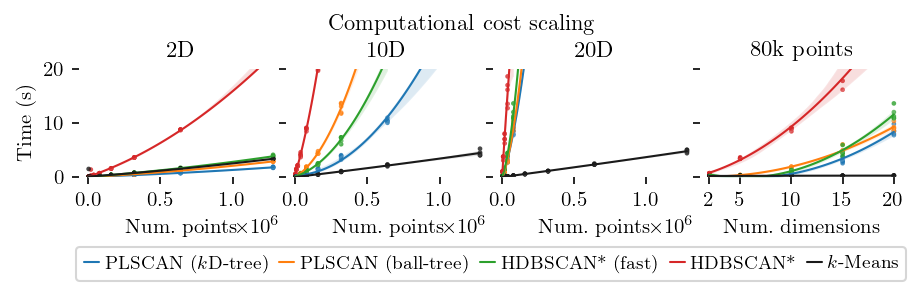

In [216]:
legend_ids = [[], [], [0, 1, 2], [3, 4]]
palette = ["C0", "C1", "C2", "C3", "k"]
ticks = [0, 10, 20]

sized_fig(1, 1.2 / 4)
for i, d in enumerate([2, 10, 20]):
    plt.subplot(2, 4, i + 1)
    plt.title(f"{d}D")
    for j, name in enumerate(alg_names):
        sns.regplot(
            benchmark_results.query(f"n_features == {d} & algorithm == '{name}'"),
            x="n_samples",
            y="elapsed_time",
            color=palette[j],
            order=2,
            line_kws={"linewidth": 1},
            scatter_kws={"s": 5, "edgecolor": "none"},
        )
    plt.xlabel("Num.~points")
    plt.ylim(0, timeout)
    plt.yticks(ticks)
    if i == 0:
        plt.ylabel("Time (s)")
    else:
        plt.ylabel("")
        plt.gca().set_yticklabels(["" for t in ticks])
plt.subplot(2, 4, 4)
for i, name in enumerate(alg_names):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.regplot(
            benchmark_results.query(f"algorithm == '{name}' & n_samples == 80000"),
            x="n_features",
            y="elapsed_time",
            color=palette[i],
            order=2,
            line_kws={"linewidth": 1},
            scatter_kws={"s": 5, "edgecolor": "none"},
        )

plt.xticks([2, 5, 10, 15, 20])
plt.ylim(0, timeout)
plt.yticks(ticks)
plt.gca().set_yticklabels(["" for t in ticks])
plt.ylabel("")
plt.xlabel("Num.~dimensions")
plt.title("80k points")
plt.suptitle("Computational cost scaling", y=1)

plt.subplot(2, 1, 2)
plt.legend(
    handles=[
        plt.Line2D([0], [0], color=p, lw=1, label=to_display_name(n))
        for p, n in zip(palette, alg_names)
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    handlelength=0.8,
    columnspacing=0.6,
    handletextpad=0.3,
    ncol=len(alg_names),
)
plt.axis("off")

plt.subplots_adjust(0.075, 0.0, 0.99, 0.8, hspace=0, wspace=0.02)
plt.savefig("images/benchmark_time.pdf", pad_inches=0)
plt.show()

## Parameter sensitivity

In [2]:
df = pd.read_parquet("data/generated/benchmark_sensitivity.parquet")
deltas = np.load("data/generated/benchmark_sensitivity_deltas.npy")
min_sample_sizes = np.load("data/generated/benchmark_sensitivity_min_sizes.npy")
new_values = np.load("data/generated/benchmark_sensitivity_perturbed_values.npy")

In [4]:
def to_display_name(input):
    parts = input.split("_")
    name = parts[0].upper()
    if name == "HDBSCAN":
        name = "HDBSCAN*"
        return f"{name} ({' '.join(parts[1:])})"
    if name == "PLSCAN":
        params = [
            p.replace("-", "--")
            .replace("density", r"$\lambda$")
            .replace("distance", "$d$")
            for p in parts[1:]
        ]
        return f"{name} ({' '.join(params)})"
    return input


def dataset_name(input):
    names = dict(
        iris="Iris",
        mnist="MNIST",
        fashion_mnist="Fashion-MNIST",
        articles_1442_5="Articles-1442-5",
        articles_1442_80="Articles-1442-80",
        audioset="Audioset~(music)",
        authorship="Authorship",
        cardiotocography="CTG",
        cell_cycle_237="CellCycle-237",
        cifar_10="CIFAR-10",
        ecoli="E.~coli",
        elegans="C.~elegans",
        mfeat_factors="Mfeat-Factors",
        mfeat_karhunen="Mfeat-Karhunen",
        newsgroups="20 Newsgroups",
        semeion="Semeion Digits",
        yeast_galactose="YeastGalactose",
    )
    return names.get(input, input)

In [5]:
# Create new data frame without the rows for non-default plscan layers
def digit_higher_than_one(char):
    return char.isdigit() and int(char) > 1


mask = df.alg_id.apply(lambda x: not digit_higher_than_one(x.split("_")[-1]))
df_default = df[mask].copy()
df_default.alg_id = df_default.alg_id.apply(
    lambda x: x if "plscan" not in x else "_".join(x.split("_")[:-1])
)

In [6]:
# Select rows with the best plscan layer at each dataset--k
plscan_df = df.query("alg_id.str.startswith('plscan')", engine="python").copy()
plscan_df["persistence"] = plscan_df.alg_id.apply(lambda x: x.split("_")[1])
plscan_df["layer"] = plscan_df.alg_id.apply(lambda x: x.split("_")[-1])
best_layer = (
    plscan_df.groupby(["data_set", "persistence", "k"])
    .apply(lambda g: g.loc[g.ari.idxmax()], include_groups=False)
    .reset_index()
)
best_layer.alg_id = best_layer.alg_id.apply(
    lambda x: "_".join(x.split("_")[:-1] + ["top"])
)
best_layer = best_layer.drop(columns=["layer", "persistence"])

In [7]:
# Combine these dataframes
df_top = pd.concat((df_default, best_layer), ignore_index=True)
df_top.groupby(["data_set", "alg_id"]).apply(
    lambda g: g.loc[g.mutual_info.idxmax(), ["mutual_info"]],
    include_groups=False,
).reset_index().round(3).pivot(
    index="alg_id", columns="data_set", values=["mutual_info"]
)

mutual_info                                       \
data_set                 articles_1442_5 articles_1442_80 audioset authorship   
alg_id                                                                          
hdbscan_eom                          1.0              1.0    0.497      0.966   
hdbscan_leaf                         1.0              1.0    0.522      0.840   
plscan_density                       1.0              1.0    0.531      0.896   
plscan_density_top                   1.0              1.0    0.537      0.883   
plscan_distance                      1.0              1.0    0.530      0.666   
plscan_distance_top                  1.0              1.0    0.537      0.896   
plscan_size                          1.0              1.0    0.500      0.883   
plscan_size-density                  1.0              1.0    0.500      0.883   
plscan_size-density_top              1.0              1.0    0.538      0.883   
plscan_size-distance                 1.0              1.0    0.500      0.666   
plscan_size-distance_top             1.0              1.0    0.538      0.896   
plscan_size_top                      1.0              1.0    0.540      0.883   

                                                                          \
data_set                 cardiotocography cell_cycle_237 cifar_10  ecoli   
alg_id                                                                     
hdbscan_eom                         0.979          0.547    0.883  0.669   
hdbscan_leaf                        0.917          0.570    0.730  0.728   
plscan_density                      0.993          0.550    0.743  0.655   
plscan_density_top                  0.993          0.550    0.905  0.655   
plscan_distance                     0.993          0.302    0.900  0.403   
plscan_distance_top                 0.993          0.550    0.905  0.668   
plscan_size                         0.966          0.553    0.915  0.655   
plscan_size-density                 0.993          0.547    0.420  0.650   
plscan_size-density_top             0.993          0.550    0.905  0.650   
plscan_size-distance                0.993          0.302    0.420  0.403   
plscan_size-distance_top            0.993          0.550    0.905  0.698   
plscan_size_top                     0.993          0.553    0.915  0.698   

                                                                   \
data_set                 elegans fashion_mnist iris mfeat_factors   
alg_id                                                              
hdbscan_eom                0.769         0.668  1.0         0.863   
hdbscan_leaf               0.815         0.561  1.0         0.880   
plscan_density             0.819         0.569  1.0         0.875   
plscan_density_top         0.821         0.620  1.0         0.875   
plscan_distance            0.819         0.543  1.0         0.821   
plscan_distance_top        0.821         0.706  1.0         0.853   
plscan_size                0.743         0.693  1.0         0.875   
plscan_size-density        0.728         0.440  1.0         0.870   
plscan_size-density_top    0.818         0.708  1.0         0.870   
plscan_size-distance       0.742         0.440  1.0         0.791   
plscan_size-distance_top   0.821         0.708  1.0         0.853   
plscan_size_top            0.818         0.712  1.0         0.875   

                                                                   \
data_set                 mfeat_karhunen  mnist newsgroups semeion   
alg_id                                                              
hdbscan_eom                       0.888  0.943      0.729   0.658   
hdbscan_leaf                      0.937  0.723      0.784   0.863   
plscan_density                    0.935  0.836      0.780   0.838   
plscan_density_top                0.938  0.947      0.789   0.838   
plscan_distance                   0.800  0.836      0.783   0.700   
plscan_distance_top               0.912  0.947      0.789   0.838   
plscan_size    

In [8]:
# Configure plotting order, colors and titles
plot_df = df_top.copy()
data_sets = sorted(plot_df.data_set.unique())
alg_ids = [
    "hdbscan_eom",
    "hdbscan_leaf",
    "plscan_size_top",
    "plscan_size",
    "plscan_size-distance_top",
    "plscan_size-distance",
    "plscan_size-density_top",
    "plscan_size-density",
    "plscan_distance_top",
    "plscan_distance",
    "plscan_density_top",
    "plscan_density",
]
palette = [
    mpl.colors.to_rgb("C0"),
    mpl.colors.to_rgb("C1"),
    lighten("C2"),
    mpl.colors.to_rgb("C2"),
    lighten("C3"),
    mpl.colors.to_rgb("C3"),
    lighten("C4"),
    mpl.colors.to_rgb("C4"),
    lighten("C5"),
    mpl.colors.to_rgb("C5"),
    lighten("C6"),
    mpl.colors.to_rgb("C6"),
]
titles = [
    "HDBSCAN*\nEOM/leaf",
    "PLSCAN\nsize",
    "PLSCAN\nsize--$d$",
    "PLSCAN\nsize--$\\lambda$",
    "PLSCAN\n$d$",
    "PLSCAN\n$\\lambda$",
]

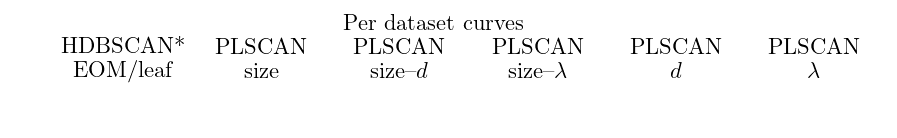

In [190]:
# Create the plots
sized_fig(1, 0.5 / 6)
max_x = plot_df.k.max()
ticks = [0, 0.5, 1]
alg_idxs = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]]
for j, ids in enumerate(alg_idxs):
    plt.subplot(1, 6, j + 1)
    plt.title(titles[j], y=0)
    plt.xlim(0, max_x)
    plt.xticks([0, 25, 50])
    plt.yticks([])
    plt.ylim(0, 1)
    if j == 0:
        plt.ylabel(f"{dataset_name(data_sets[0])}\nARI.", labelpad=0, color="w")
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.suptitle("Per dataset curves", y=1)
    plt.subplots_adjust(bottom=0, right=1, top=1, left=0.08, wspace=0.01)
    plt.savefig("images/parameter_sensitivity_header.pdf", pad_inches=0)

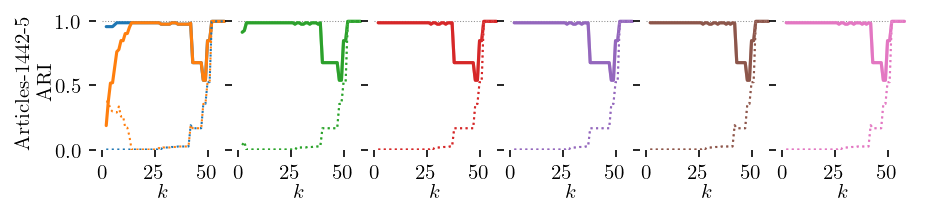

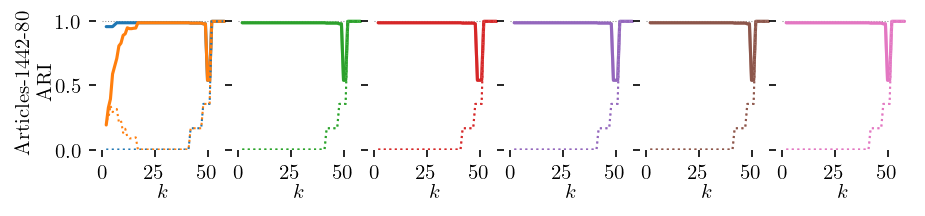

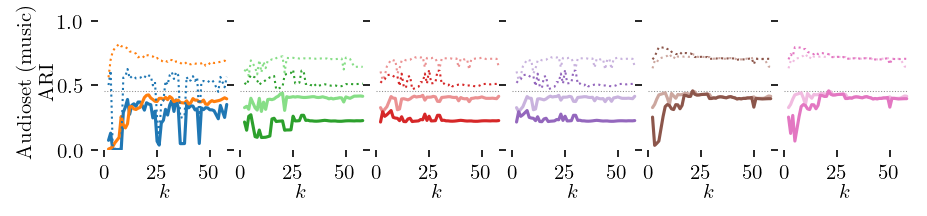

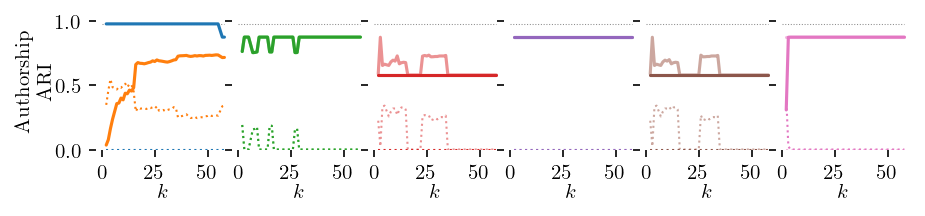

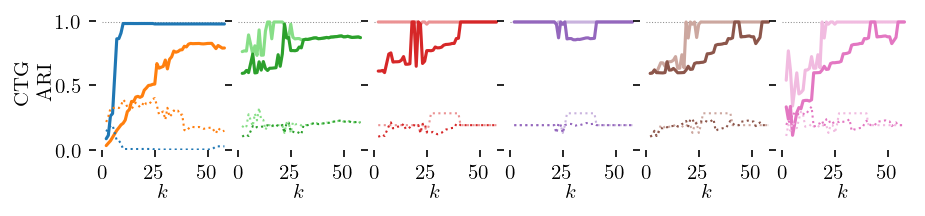

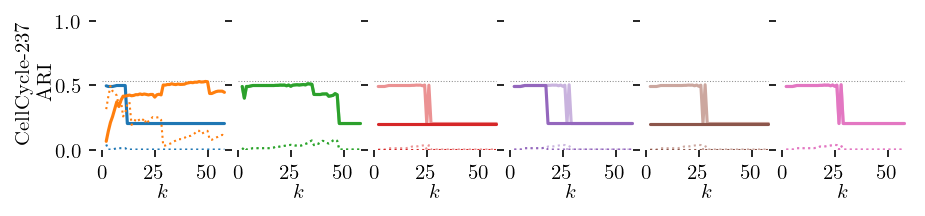

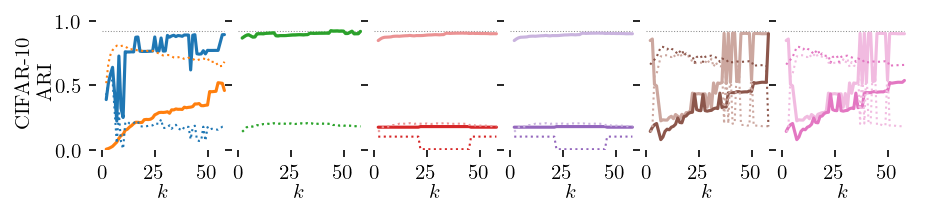

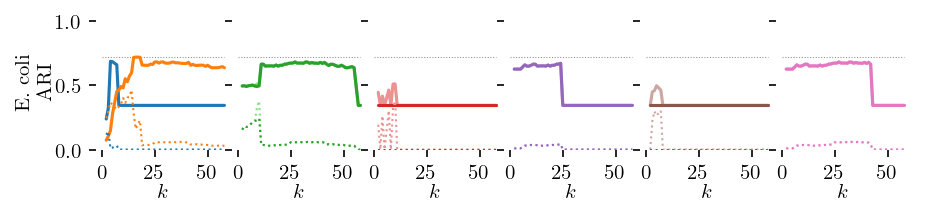

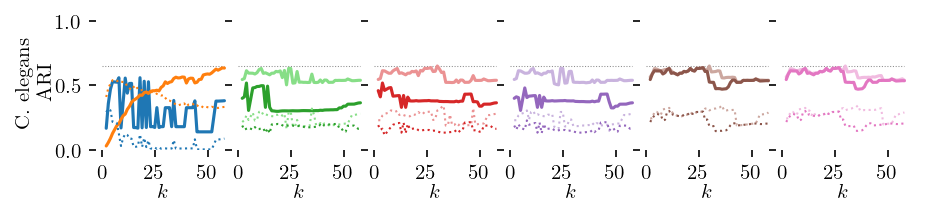

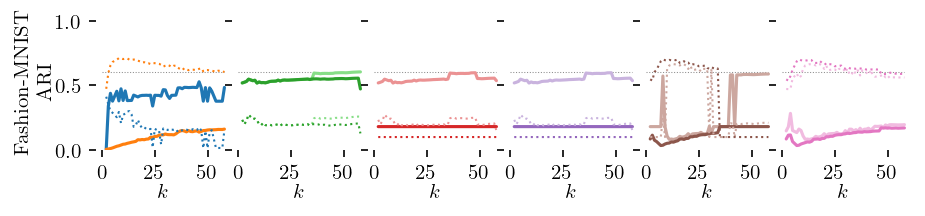

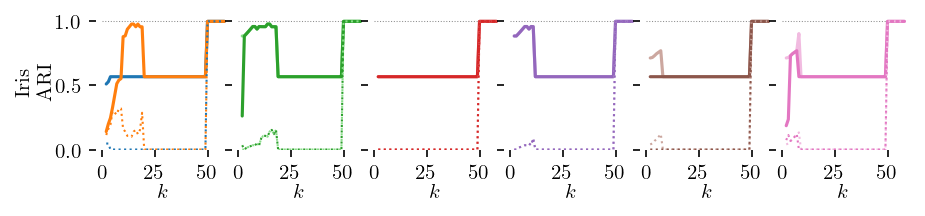

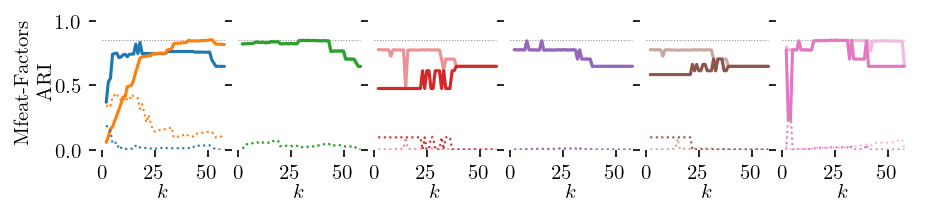

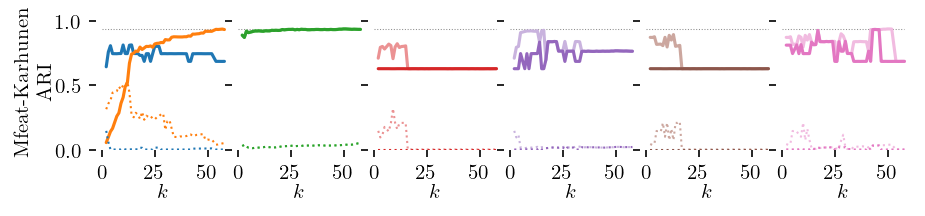

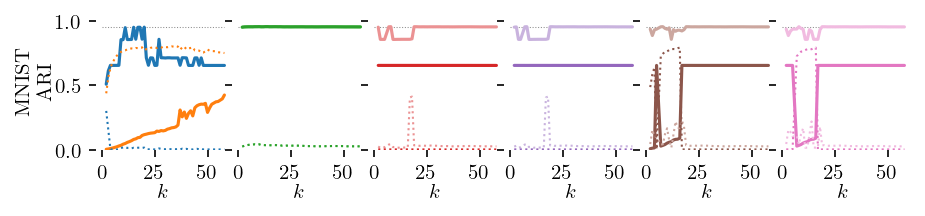

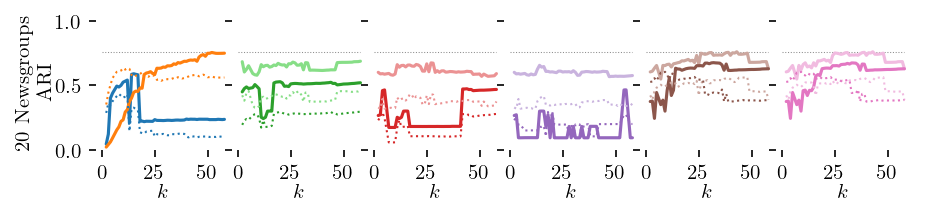

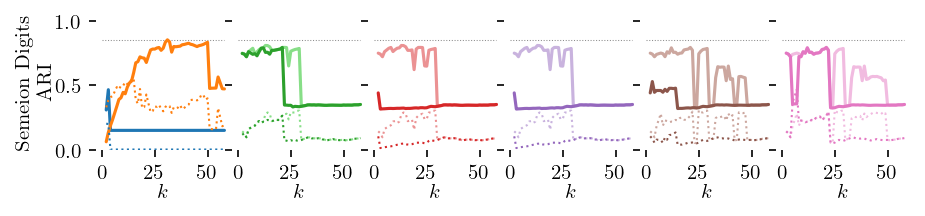

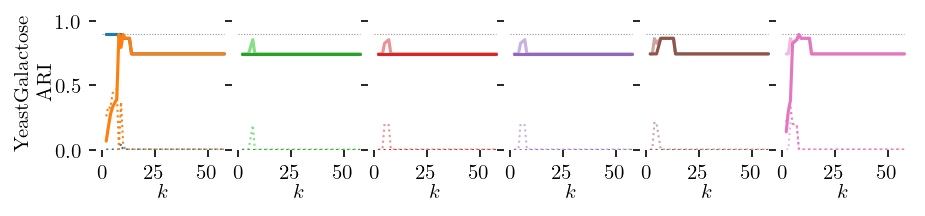

In [191]:
for i, data_name in enumerate(data_sets):
    sized_fig(1, 1.3 / 6)
    ddf = plot_df.query(f'data_set == "{data_name}"')
    max_x = ddf.k.max()
    max_y = ddf.ari.max()
    for j, ids in enumerate(alg_idxs):
        plt.subplot(1, 6, j + 1)
        plt.hlines(
            max_y,
            0,
            max_x,
            colors=lighten("k"),
            linestyles=":",
            linewidth=0.5,
        )
        sns.lineplot(
            data=ddf,
            x="k",
            y="ari",
            hue="alg_id",
            hue_order=[alg_ids[idx] for idx in ids],
            errorbar=None,
            palette=[palette[idx] for idx in ids],
            legend=False,
        )
        sns.lineplot(
            data=ddf,
            x="k",
            y="noise_fraction",
            hue="alg_id",
            hue_order=[alg_ids[idx] for idx in ids],
            errorbar=None,
            palette=[palette[idx] for idx in ids],
            linestyle=":",
            linewidth=1,
            legend=False,
        )
        plt.xlabel("$k$", labelpad=0)
        plt.xticks([0, 25, 50])
        plt.ylim(0, 1.05)
        plt.yticks(ticks)
        if j == 0:
            plt.ylabel(f"{dataset_name(data_name)}\nARI", labelpad=0)
        else:
            plt.ylabel("")
            plt.gca().set_yticklabels(["" for t in ticks])
        plt.subplots_adjust(bottom=0.27, right=1, left=0.095, wspace=0.01, top=0.96)
        plt.savefig(f"images/parameter_sensitivity_{data_name}.pdf", pad_inches=0)
plt.show()

In [9]:
def scale_quality(group):
    max_q = group.ari.max()
    group["scaled_quality"] = group.ari / max_q
    return group


plot_df = (
    plot_df.groupby(["data_set"])
    .apply(scale_quality, include_groups=False)
    .reset_index()
)

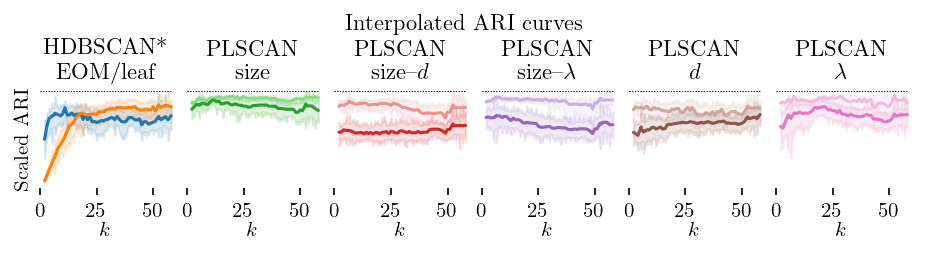

In [195]:
sized_fig(1, 1.5 / 6)
max_y = plot_df.scaled_quality.max()
for j, ids in enumerate(alg_idxs):
    plt.subplot(1, 6, j + 1)
    for i, idx in enumerate(ids):
        alg_id = alg_ids[idx]
        plt.hlines(max_y, 0, max_x, colors="k", linestyles=":", linewidth=0.5)
        regplot_lowess_ci(
            plot_df.query(f'alg_id == "{alg_id}"'),
            x="k",
            y="scaled_quality",
            ci_level=95,
            n_boot=100,
            lowess_frac=0.05,
            color=palette[idx],
            scatter=False,
        )
        plt.title(titles[j])
        plt.xlabel("$k$", labelpad=0)
        plt.ylim(0, 1)
        plt.yticks([])
        plt.xticks([0, 25, 50])
        if j == 0:
            plt.ylabel("Scaled ARI", labelpad=0)
        else:
            plt.ylabel("")
plt.suptitle("Interpolated ARI curves", y=1)
plt.subplots_adjust(bottom=0.23, right=1, left=0.022, wspace=0.02, top=0.66)
plt.savefig("images/parameter_sensitivity_scaled.pdf", pad_inches=0)
plt.show()

In [10]:
sensitivity_records = []
for data_set, alg_id in product(df_top.data_set.unique(), df_top.alg_id.unique()):
    sub_df = df_top.query(f"data_set == '{data_set}' & alg_id == '{alg_id}'")
    vals = defaultdict(lambda: np.nan, {k: v for k, v in zip(sub_df.k, sub_df.ari)})
    lookup_fun = np.vectorize(lambda x: vals[x])
    initial_val = lookup_fun(min_sample_sizes)[np.newaxis, :, :]
    perturbed_val = lookup_fun(new_values)
    with np.errstate(divide="ignore", invalid="ignore"):
        diff = np.abs((perturbed_val - initial_val) / (perturbed_val + initial_val))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sensitivity = np.nanmean(diff, axis=(1, 2))
    for delta, sensitivity in zip(deltas[:, 0], sensitivity):
        sensitivity_records.append(
            {
                "data_set": data_set,
                "alg_id": alg_id,
                "perturbation": delta,
                "sensitivity": sensitivity,
            }
        )

# Convert to pandas
df_sens = pd.DataFrame.from_records(sensitivity_records)
df_sens.head()

,data_set,alg_id,perturbation,sensitivity
0,iris,plscan_size,2,0.025465
1,iris,plscan_size,5,0.047526
2,iris,plscan_size,10,0.145793
3,iris,plscan_distance,2,0.000000
4,iris,plscan_distance,5,0.005621


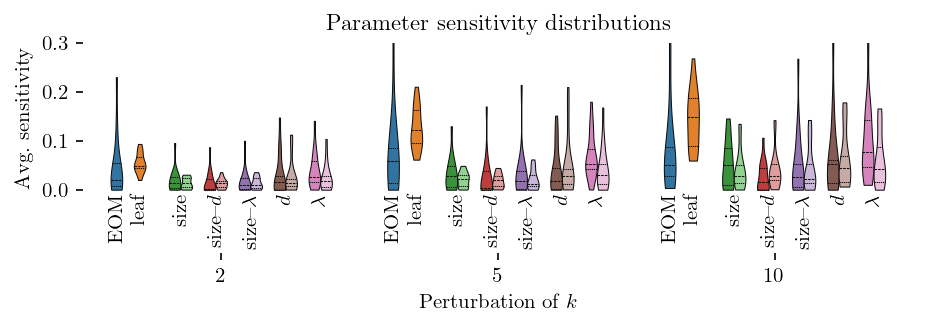

In [14]:
sized_fig(1, 1 / 3)

plot_df = df_sens.copy()
plot_df.alg_id = plot_df.alg_id.apply(to_display_name)

alg_order = [
    0,
    None,
    1,
    None,
    None,
    3,
    2,
    None,
    5,
    4,
    None,
    7,
    6,
    None,
    9,
    8,
    None,
    11,
    10,
]
hue_order = [to_display_name(alg_ids[x]) if x is not None else None for x in alg_order]
alg_palette = [palette[x] if x is not None else "k" for x in alg_order]
ax = sns.violinplot(
    data=plot_df,
    y=plot_df.sensitivity,
    x=pd.Categorical(plot_df.perturbation),
    hue=plot_df.alg_id,
    hue_order=hue_order,
    density_norm="count",
    palette=alg_palette,
    legend=False,
    inner="quartiles",
    linewidth=0.5,
    cut=0,
    width=0.8,
)

u_perts = plot_df.perturbation.unique().tolist()
for (alg_id, perturbation), _ in plot_df.groupby(
    ["alg_id", "perturbation"]
).groups.items():
    pert_order = u_perts.index(perturbation)
    alg_order = hue_order.index(alg_id)
    w = 0.8 / 2
    o = pert_order - w + (alg_order) * w / len(hue_order) * 2 + w / len(hue_order)
    name = alg_id.split("(")[1][:-1]
    if name in ["eom", "leaf"]:
        plt.text(
            o,
            -0.01,
            f"{name.replace("eom", "EOM")}",
            rotation=90,
            fontsize=fontsize["small"],
            ha="center",
            va="top",
        )
    if "top" in name:
        name = name.replace(" top", "")
        plt.text(
            o - w / len(hue_order),
            -0.01,
            f"{name}",
            rotation=90,
            fontsize=fontsize["small"],
            ha="center",
            va="top",
        )

max_y = 0.3
# plt.xlim(-.44, 2.44)
plt.ylim(-0.13, max_y)
plt.yticks([0, 0.1, 0.2, 0.3])
plt.xlabel("Perturbation of $k$")
plt.ylabel("Avg.~sensitivity", y=0.64)
plt.title("Parameter sensitivity distributions")
plt.subplots_adjust(left=0.078, right=1, bottom=0.2, top=0.9)
plt.savefig("images/parameter_sensitivity_violinplot.pdf", pad_inches=0)
plt.show()